In [1]:
from math import log

# 特征标签
FEAT_LABEL = ['age', 'prescript', 'astigmatic', 'tearRate']
# 特征可选值
FEAT_DICT = {
    'age': ['young', 'pre', 'presbyopic'],
    'prescript': ['myope', 'hyper'],
    'astigmatic': ['no', 'yes'],
    'tearRate': ['normal', 'reduced']
}
# 分类标签
RES_LABEL = ['hard', 'soft', 'no lenses']

def index_of(arr, val):
    for i in range(len(arr)):
        if arr[i] == val:
            return i
    return -1

# 将文本数组转化为特征向量
def arr_to_vector(arr):
    res = arr
    for i in range(len(arr) - 1):
        res[i] = index_of(FEAT_DICT[FEAT_LABEL[i]], arr[i])
    return res

# 数据预处理
def pre_process(path):
    res = []
    with open(path, 'r') as f:
        line = f.readline()
        while line:
            arr = line[:-1].split('\t')
            res.append(arr_to_vector(arr))
            line = f.readline()
    return res

# 香农熵
def shannon(data_set):
    category_dict = {}
    for vec in data_set:
        category = vec[-1]
        if category in category_dict:
            category_dict[category] += 1
        else:
            category_dict[category] = 1
    res = 0.0
    for category in category_dict:
        p = float(category_dict[category]) / len(data_set)
        res -= p * log(p, 2)
    return res

# 划分数据集
def get_divided_set(data_set, feat_idx, feat_val):
    res = []
    for vec in data_set:
        if vec[feat_idx] == feat_val:
            new_vec = vec[:feat_idx]
            new_vec.extend(vec[feat_idx+1:])
            res.append(new_vec)
    return res

# 寻找最优划分方式
def find_best_feat(data_set):
    shannon_raw = shannon(data_set)
    max_info_gain = 0.0
    best_feat_idx = 0
    for i in range(len(data_set[0])-1):
        feat_vals = set([d[i] for d in data_set])
        shannon_divided = 0.0
        for j in range(len(feat_vals)):
            divided_set = get_divided_set(data_set, i, j)
            p = float(len(divided_set)) / len(data_set)
            shannon_divided += p * shannon(divided_set)
        info_gain = shannon_raw - shannon_divided
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            best_feat_idx = i
    return best_feat_idx

# 构建决策树
def create_dicision_tree(data_set, labels):
    # 所有分类标签全部相同, 完成分类
    categories = [d[-1] for d in data_set]
    if categories.count(categories[0]) == len(categories):
        return categories[0]
    # 如果所有特征都使用过了依然不能唯一确定, 返回最多的分类
    if len(data_set[0]) == 1:
        cat_dict = {}
        for cat in categories:
            if cat in cat_dict:
                cat_dict[cat] += 1
            else:
                cat_dict[cat] = 1
        max_cat = ''
        max_cat_num = 0
        for cat in cat_dict:
            if cat_dict[cat] > max_cat_num:
                max_cat = cat
                max_cat_num = cat_dict[cat]
        return max_cat
    # 构建树
    best_feat = find_best_feat(data_set)
    best_feat_label = labels[best_feat]
    del labels[best_feat]
    tree = { best_feat_label: {} }
    feat_vals = set([d[best_feat] for d in data_set])
    for val in feat_vals:
        # 注意要复制!传递的是引用!
        labels_copy = labels[:]
        # 构建当前最佳划分特征每个值的子决策树
        tree[best_feat_label][val] = create_dicision_tree(get_divided_set(data_set, best_feat, val), labels_copy)
    return tree 

file_path = 'lenses.txt'
data_set = pre_process(file_path)
tree = create_dicision_tree(data_set, FEAT_LABEL)
print(tree)

{'tearRate': {0: {'astigmatic': {0: {'age': {0: 'soft', 1: 'soft', 2: {'prescript': {0: 'no lenses', 1: 'soft'}}}}, 1: {'prescript': {0: 'hard', 1: {'age': {0: 'hard', 1: 'no lenses', 2: 'no lenses'}}}}}}, 1: 'no lenses'}}


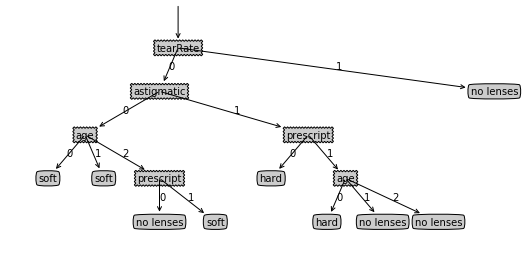

In [72]:
# 将得到的树绘制成图像
import matplotlib.pyplot as plt

# 绘制参考了给出的参考代码
def get_width(tree):
    res = 0
    first_node = list(tree.keys())[0]
    first_node_tree = tree[first_node]
    for node in first_node_tree.keys():
        if type(first_node_tree[node]).__name__ == 'dict':
            res += get_width(first_node_tree[node])
        else:
            res += 1
    return res

def get_height(tree):
    res = 0
    first_node = list(tree.keys())[0]
    first_node_tree = tree[first_node]
    for node in first_node_tree.keys():
        h = 0
        if type(first_node_tree[node]).__name__ == 'dict':
            h = 1 + get_height(first_node_tree[node])
        else:
            h = 1
        if h > res:
            res = h
    return res

def paint_line_text(child, parent, text):
    x = (parent[0] - child[0]) / 2.0 + child[0]
    y = (parent[1] - child[1]) / 2.0 + child[1]
    paint.ax1.text(x, y, text)

def paint_node(text, pos, parent, node_type):
    paint.ax1.annotate(
        text,
        xy = parent,
        xycoords = 'axes fraction',
        xytext = pos,
        va='center',
        ha='center',
        bbox=node_type,
        arrowprops=dict(arrowstyle='<-')
    )

def create_node(tree, parent, text):
    width = get_width(tree)
    height = get_height(tree)
    first_node = list(tree.keys())[0]
    pos = (create_node.xOff + (1.0 + float(width)) / 2.0 / create_node.totalW, create_node.yOff)
    paint_line_text(pos, parent, text)
    paint_node(first_node, pos, parent, dict(boxstyle='sawtooth', fc='0.8'))
    first_node_tree = tree[first_node]
    create_node.yOff = create_node.yOff - 1.0 / create_node.totalD
    for node in first_node_tree.keys():
        if type(first_node_tree[node]).__name__ == 'dict':
            create_node(first_node_tree[node], pos, str(node))
        else:
            create_node.xOff = create_node.xOff + 1.5 / create_node.totalW
            paint_node(first_node_tree[node], (create_node.xOff, create_node.yOff), pos, dict(boxstyle='round4', fc='0.8'))
            paint_line_text((create_node.xOff, create_node.yOff), pos, str(node))
    create_node.yOff = create_node.yOff + 1.0 / create_node.totalD

def paint(tree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    data = dict(xticks=[], yticks=[])
    paint.ax1 = plt.subplot(111, frameon=False, **data)
    create_node.totalW = WIDTH
    create_node.totalD = HEIGHT
    create_node.xOff = -0.5 / WIDTH
    create_node.yOff = 1.0
    create_node(tree, (0.5, 1.2), '')
    plt.show()

paint(tree)